In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Imports

In [2]:
from __future__ import print_function, division
from collections import deque

import numpy as np
import os
import cv2
import glob
import scipy

from keras.utils import Sequence
import keras.backend as K

import matplotlib.pyplot as plt
import tqdm

Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1001663125421784770
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1713774349266743644
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14609329827169323424
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5485559808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2606700320660342263
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
%matplotlib notebook

### Functions

In [6]:
# dataset_path = "/media/ankurrc/new_volume/usl/drivable_area_project/datasets/kitti/data_semantics/training/"
dataset_path = "/home/ankurrc/files/usl/drivable_area/bdd_custom"
road_class = 7

In [7]:
# image_path = os.path.join(dataset_path, "image_2")
image_path = os.path.join(dataset_path, "images")
# label_path = os.path.join(dataset_path, "semantic")
label_path = os.path.join(dataset_path, "labels")

In [8]:
label_names = os.listdir(label_path)
label_names = [label_name.split("_")[0] for label_name in label_names]
image_names = os.listdir(image_path)
image_names = [image_name.split(".")[0] for image_name in image_names]
labels = set.intersection(set(label_names), set(image_names))
labels = list(labels)

In [8]:
label_names[0], image_names[0], len(labels)

('84251c1f-517c5b71', '94798a57-0b4df0c9', 10000)

In [11]:
lbl = cv2.imread(os.path.join(label_path, labels[10] + "_drivable_id.png"))
img = plt.imread(os.path.join(image_path, labels[10] + ".jpg"))

<IPython.core.display.Javascript object>


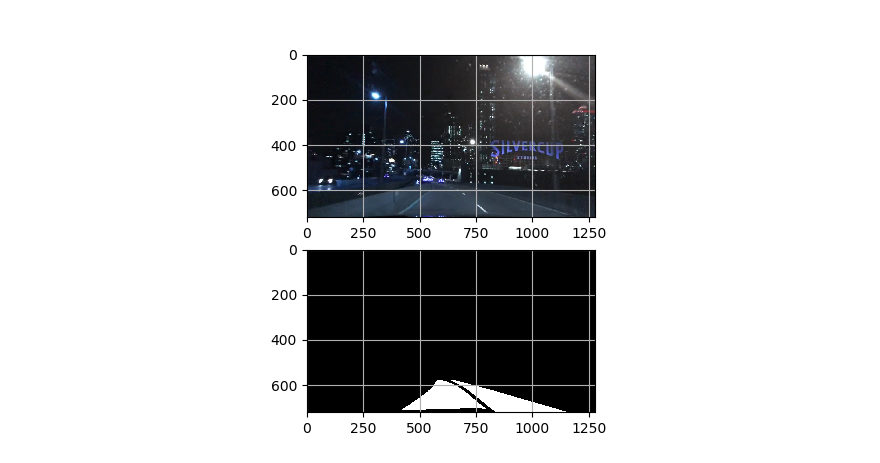

In [14]:
fig, ax = plt.subplots(2, 1)
ax[0].grid(None)
ax[0].imshow(img)
ax[1].grid(None)
ax[1].imshow(np.logical_or(lbl == 1, lbl == 2).astype(int)*255)

In [9]:
labels = labels[:10002]

In [10]:
# bar = tqdm.tqdm(total=len(labels))
sizes = [None]*len(labels)
bad = []
for i, lbl in enumerate(labels):
    path = os.path.join(label_path, lbl+ "_drivable_id.png")
    try:
        label = plt.imread(path)
        sizes[i] = label.shape
    except ValueError as e:
        bad.append(lbl)
        print(str(i) + "Failed on:" + lbl)
        print(e)
#     label*=255
#     bar.update()

9238Failed on:9eb69cb0-42fa4b5d
invalid PNG header
9473Failed on:50b115d6-4b08a666
invalid PNG header


In [11]:
for i in bad:
    labels.remove(i)

In [12]:
len(labels)

10000

In [13]:
sizes = set(sizes)

In [14]:
sizes

{None, (720, 1280)}

In [15]:
class SemanticDataGenerator(Sequence):
    #'Generates data for Keras'
    def __init__(self, dataset_image_path=None, dataset_mask_path=None, batch_size=32, dim=None, shuffle=True):
        #'Initialization'
        if dim is not None:
            assert(len(dim)==2), "Need a tuple of height, width"
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset_image_path, self.dataset_mask_path = dataset_image_path, dataset_mask_path
        self.__prepare_file_list()
        self.on_epoch_end()
        
    def __prepare_file_list(self):
        self.file_list = glob.glob1(self.dataset_image_path, "*.png")
        self.id2file = dict(((i, file) for i, file in enumerate(self.file_list)))

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index=None):
        #'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.id2file[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp=None):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = deque(maxlen=self.batch_size)
        Y = deque(maxlen=self.batch_size)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            x = cv2.imread(os.path.join(self.dataset_image_path, ID))[:, :, ::-1]
            if self.dim is not None:
                x = cv2.resize(x, self.dim)
            X.append(x)

            # Store class
            y = cv2.imread(os.path.join(self.dataset_mask_path, ID), 0)
            if self.dim is not None:
                y = cv2.resize(y, self.dim)
            y = (y == 7).astype(int)
            Y.append(y)

        return np.array(X), np.array(Y)

In [17]:
class BddDataGenerator(SemanticDataGenerator):
    #'Generates data for Keras'
    def __init__(self, dataset_image_path=None, dataset_mask_path=None, batch_size=32, dim=None, shuffle=True, file_ids=None):
        #'Initialization'
        super(BddDataGenerator, self).__init__(dataset_image_path=dataset_image_path, dataset_mask_path=dataset_mask_path, batch_size=batch_size, dim=dim, shuffle=shuffle)
        self.__prepare_file_list(file_ids=file_ids)
        super(BddDataGenerator, self).on_epoch_end()
        
    def __prepare_file_list(self, file_ids=None):
        if file_ids is not None:
            self.file_list = file_ids
            self.id2file = dict(((i, file) for i, file in enumerate(self.file_list)))
            
    def __getitem__(self, index=None):
        #'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.id2file[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def __data_generation(self, list_IDs_temp):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = deque(maxlen=self.batch_size)
        Y = deque(maxlen=self.batch_size)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            x = cv2.imread(os.path.join(self.dataset_image_path, ID + ".jpg"))[:, :, ::-1]
            if self.dim is not None:
                x = cv2.resize(x, self.dim)
            X.append(x)

            # Store class
            y = cv2.imread(os.path.join(self.dataset_mask_path, ID + "_drivable_id.png"))
            y = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
            if self.dim is not None:
                y = cv2.resize(y, self.dim)
            y = np.logical_or(y == 1, y == 2).astype(int)
            Y.append(y)

        return np.array(X), np.array(Y)

In [18]:
datagen = BddDataGenerator(dataset_image_path=image_path, dataset_mask_path=label_path, dim=(900, 270), batch_size=4, shuffle=True, file_ids=labels)

In [19]:
i = iter(datagen)

In [22]:
for it in i:
    X, y = it
    break;

In [23]:
X.shape, y.shape

((4, 270, 900, 3), (4, 270, 900))

<IPython.core.display.Javascript object>


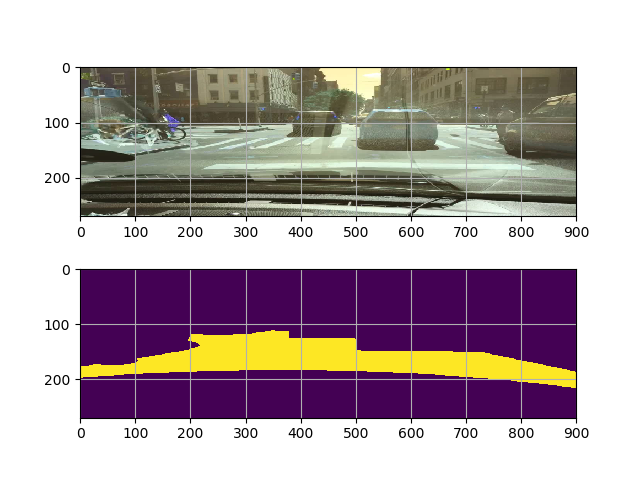

In [24]:
fig, ax = plt.subplots(2, 1)
ax[0].grid(None)
ax[0].imshow(X[0])
ax[1].grid(None)
ax[1].imshow(y[0])

In [32]:
save_dir = "/media/ankurrc/new_volume/usl/drivable_area_project/datasets/bdd/custom"
img_save_dir = os.path.join(save_dir, "images")
lbl_save_dir = os.path.join(save_dir, "labels")
for ID in tqdm.tqdm(labels):
        # Store sample
        img_name = ID + ".jpg"    
        x = cv2.imread(os.path.join(image_path, img_name))[:, :, ::-1]
        ret = cv2.imwrite(os.path.join(img_save_dir, img_name), x)
        if not ret:
            raise Exception("could not write file: {}".format(img_name))
            
        # Store class
        lbl_name = ID + "_drivable_id.png"
        y = cv2.imread(os.path.join(label_path, lbl_name))
        y = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
        y = np.logical_or(y == 1, y == 2).astype(int)
        ret = cv2.imwrite(os.path.join(lbl_save_dir, lbl_name), y)
        if not ret:
            raise Exception("could not write file: {}".format(lbl_name))

100%|██████████| 10000/10000 [06:00<00:00, 27.72it/s]
